# Performance on simulated protons and muons

In [28]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from helpers import *
from loaders import *
from initializers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
today = '19_11_20'

In [30]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon/pdfs/

In [31]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon/'
save_folder_pdfs = save_folder + 'pdfs/'

In [32]:
branches = [
    'run',
    'sub',
    'evt',
    
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_end_process',
    
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'generation',
    'trk_daughters',
    'shr_daughters',

    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',
    
    'trk_pid_chipr_u',
    'trk_pid_chipr_v',
    'trk_pid_chipr_y',
    'trk_pid_chimu_y',
    'trk_bragg_p_y',
    'trk_bragg_mu_y',
    
    'trk_bragg_p_three_planes',

    'trk_len',
    'longest',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'x_u',
#     'x_v',
#     'x_y',
    
#     'y_u',
#     'y_v',
#     'y_y',
    
#     'z_u',
#     'z_v',
#     'z_y',
    
#     'dir_x_u',
#     'dir_x_v',
#     'dir_x_y',
    
#     'dir_y_u',
#     'dir_y_v',
#     'dir_y_y',
    
#     'dir_z_u',
#     'dir_z_v',
#     'dir_z_y',
]

In [58]:
file_bnb = '~/Desktop/MicroBooNE/calorimetry_likelihood/v03/bnb_nu/out.root'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.7
split_factor2 = 1
root_file = uproot.open(file_bnb)[folder][tree]
entry_split = int(len(root_file) * split_factor)
entry_split2 = int(len(root_file) * split_factor2)
array_train = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
array_test = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [59]:
for array in [array_train, array_test]:
    initialisation_for_caloriemtry_data_mc(array)

In [60]:
def selection_for_train(array):
    return (array['backtracked_completeness'] > 0.9) &\
           (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           (array['non_inelastic']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0) &\
           ((abs(array['backtracked_pdg']) == 13) | (abs(array['backtracked_pdg']) == 2212))

def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append((array['rr'+plane].max() != array['rr'+plane]) & (array['rr'+plane].min() != array['rr'+plane]))
    return aux

In [61]:
selection_train = selection_for_train(array_train)
selection_train_planes = selection_planes(array_train)
selection_test = selection_for_train(array_test)
selection_test_planes = selection_planes(array_test)

muon_train = (abs(array_train['backtracked_pdg']) == 13)
proton_train = (abs(array_train['backtracked_pdg']) == 2212)

muon_test = (abs(array_test['backtracked_pdg']) == 13)
proton_test = (abs(array_test['backtracked_pdg']) == 2212)

In [71]:
parameters_names = ['rr', 'pitch']
parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
                  [.0, 0.6, 1, 1.5, 3, 30]]

dedx_var = 'dedx'
dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [72]:
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train, quality_masks_planes=selection_train_planes)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test, quality_masks_planes=selection_test_planes)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [73]:
array = caloLike_test.array
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 13)    
    caloLike_train.buildLookUpTableMC(i, 2212)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [13, 2212])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_test.lookup_tables = caloLike_train.lookup_tables    
    
    array['like_13_{}'.format(i)] = caloLike_train.likelihoodWholeDataset(array=array, 
                                      plane_num=i, 
                                      pdg_code=13)
    array['like_2212_{}'.format(i)] = caloLike_train.likelihoodWholeDataset(array=array, 
                                      plane_num=i, 
                                      pdg_code=2212)
    array['like_13_sum_{}'.format(i)] = array['like_13_{}'.format(i)].sum()
    array['like_2212_sum_{}'.format(i)] = array['like_2212_{}'.format(i)].sum()
    array['log_like_ratio_{}'.format(i)] = array['like_13_sum_{}'.format(i)] - array['like_2212_sum_{}'.format(i)]
    
array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:129: RuntimeWarning: invalid value encountered in true_divide
  hist_total/hist_partial[..., np.newaxis],
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:140: RuntimeWarning: divide by zero encountered in log
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:140: RuntimeWarning: invalid value encountered in subtract
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:245: RuntimeWarning: divide by zero encountered in log
  return np.log(self.lookup_tables[pdg_code][plane_num][lookup_index])
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in add
/home/nic/.local/lib/python3.7/site-packages/ipykernel_laun

In [76]:
caloLike_train.printCplusplusCode(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/outlookup.h', planes=[0, 1, 2])

In [74]:
caloLike_train.logLikelihoodRatioOneHit(2, 2.5, [15, 1])

734


3.556321322502619

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [75]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=13, 
                                  parameters_value=bin_center, 
                                  label='muon')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=2212, 
                                  parameters_value=bin_center, 
                                  label='proton')
        plt.xlim(0, 30)
        plt.tight_layout()
        plt.savefig(save_folder_pdfs+'plane_{}_rr_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]), dpi=250)
        plt.close()

## Plots

In [95]:
nan_mask = np.isnan(caloLike_test.array['log_like_ratio_0'])

In [104]:
out_0 = caloLike_test.array['like_13_0'][nan_mask][0] - caloLike_test.array['like_2212_0'][nan_mask][0]

In [108]:
caloLike_test.array['like_13_0'][nan_mask][0]

array([ -0.73660529,  -1.53117265,  -3.76242336,  -4.90238996,
        -4.43240284,  -5.14215077,  -4.4915632 ,  -4.4915632 ,
        -4.74420723,  -6.02514107,  -8.4038005 ,  -9.48436713,
               -inf,  -4.75687269,  -4.42706714,  -3.88528745,
        -2.75260487,  -6.1142556 ,  -5.72121301,  -9.7957786 ,
        -9.92772978,  -9.92772978,  -8.9172282 ,  -5.07935912,
        -2.69604188,  -1.98871007,   0.49588355,  -2.69604188,
        -1.98871007,  -1.91697939,  -1.91697939,  -1.91697939,
        -8.02404375,  -1.22543392,  -6.99115811,  -2.01287736,
        -9.53590341, -11.82590972,  -7.07395157,  -4.69743736,
        -7.07395157, -10.68767164,  -8.97549961,  -7.07395157,
       -11.82590972,  -8.71239441,  -2.01287736,  -7.88724614,
        -7.58714154,  -6.99115811,  -5.60812997,  -1.45288072,
        -4.10802873,  -4.10802873,  -3.32356339,  -2.31959483,
        -3.32356339,  -4.10802873,  -4.67063703,  -4.10802873,
        -3.32356339,  -2.31959483,  -2.24376893,  -1.91

In [109]:
caloLike_test.array['like_2212_0'][nan_mask][0]

array([ -1.56603146,  -2.61711861,  -3.14823324,  -2.62504991,
        -2.02789022,  -1.97144839,  -1.87352285,  -1.87352285,
        -1.55408782,  -2.15383382,  -5.64308841,  -8.2565774 ,
        -9.21208884,  -2.88423677,  -2.00089897,  -1.1596697 ,
        -0.80271251,  -3.87730977,  -3.12700417,  -8.73069037,
        -8.71454824,  -8.71454824,  -7.12125245,  -2.24461499,
        -2.80141599,  -2.04613703,   0.33072814,  -2.80141599,
        -2.04613703,  -1.80915121,  -1.80915121,  -1.80915121,
               -inf,  -0.48396817,         -inf,  -0.36179004,
        -8.44246965, -10.23422911,  -7.3770667 ,  -5.11084926,
        -7.3770667 , -10.12148455,  -9.02287226,  -7.3770667 ,
       -10.23422911,  -7.93164402,  -0.36179004,  -7.60887063,
        -6.91572345,         -inf,  -5.78228554,  -3.14322821,
        -2.78655326,  -2.78655326,  -1.37556629,  -0.44956674,
        -1.37556629,  -2.78655326,  -3.83637539,  -2.78655326,
        -1.37556629,  -0.44956674,  -2.35569492,  -1.80

In [120]:
caloLike_test.array['pitch_u'][nan_mask][0][np.isinf(out_0)]

array([0.6801861, 1.935011 , 1.4879292, 1.4829836], dtype=float32)

In [116]:
caloLike_test.array['rr_u'][nan_mask][0][np.isinf(out_0)]

array([ 26.396805, 112.7852  , 119.39753 , 141.77783 ], dtype=float32)

In [122]:
caloLike_test.array['dedx_u'][nan_mask][0][np.isinf(out_0)]

array([34.12996  ,  9.7887745,  8.782697 ,  8.564527 ], dtype=float32)

In [121]:
caloLike_test.array['dedx_u'][nan_mask][0]

array([  0.30434045,   1.8919019 ,   5.4554305 ,   7.1714277 ,
         6.3510528 ,   5.893349  ,   4.7606807 ,   4.556861  ,
         4.576041  ,   6.0978637 ,   9.535543  ,  22.724012  ,
        34.12996   ,   5.449924  ,   4.677571  ,   4.0067334 ,
         3.2453551 ,   5.2702456 ,   4.977523  ,  15.78696   ,
        22.478516  ,  23.158466  ,  14.101481  ,   4.118417  ,
         1.9020793 ,   0.9043464 ,   0.3219621 ,   1.6269192 ,
         0.7215512 ,   0.5504858 ,   0.8087039 ,   0.60206395,
         9.7887745 ,   2.0916996 ,   8.782697  ,   2.7930028 ,
        22.437988  ,  85.23366   ,  13.698514  ,   6.3808713 ,
        12.149239  , 259.88834   ,  29.666986  ,  13.124093  ,
        57.52572   ,  18.882315  ,   2.7353513 ,  10.050162  ,
         9.16334   ,   8.564527  ,   5.1674957 ,   1.4517564 ,
         3.8479788 ,   3.881464  ,   3.4765706 ,   2.9677296 ,
         3.2878277 ,   3.9201708 ,   4.27577   ,   3.9377367 ,
         3.155009  ,   2.9611747 ,   1.5164125 ,   0.55

In [112]:
out_0

array([ 0.82942617,  1.08594596, -0.61419012, -2.27734006, -2.40451263,
       -3.17070238, -2.61804035, -2.61804035, -3.19011941, -3.87130725,
       -2.7607121 , -1.22778974, -1.87263592, -2.42616817, -2.72561775,
       -1.94989235, -2.23694583, -2.59420884, -1.06508824, -1.21318155,
       -1.21318155, -1.79597575, -2.83474413,  0.10537411,  0.05742696,
        0.16515541,  0.10537411,  0.05742696, -0.10782818, -0.10782818,
       -0.10782818, -0.74146575, -1.65108732, -1.09343376, -1.59168061,
        0.30311513,  0.4134119 ,  0.30311513, -0.56618709,  0.04737265,
        0.30311513, -1.59168061, -0.78075039, -1.65108732, -0.27837551,
       -0.6714181 ,  0.17415556,  1.69034749, -1.32147546, -1.32147546,
       -1.9479971 , -1.87002809, -1.9479971 , -1.32147546, -0.83426165,
       -1.32147546, -1.9479971 , -1.87002809,  0.11192599, -0.10782818,
       -0.83426165, -0.10169205])

In [106]:
out_0[~np.isinf(out_0)].sum()

-68.6163495923307

In [77]:
def add_norm_variable(array, var, scale=100):
    array[var+'_n'] = 2/math.pi*np.arctan(array[var]/scale)

In [79]:
add_norm_variable(caloLike_test.array, 'trk_pid_chipr_y')
add_norm_variable(caloLike_test.array, 'log_like_ratio_0')
add_norm_variable(caloLike_test.array, 'log_like_ratio_1')
add_norm_variable(caloLike_test.array, 'log_like_ratio_2')

In [80]:
def selection_for_test(array):
    return selection_for_train(array) &\
              ~np.isnan(array['log_like_ratio_0']) &\
              ~np.isnan(array['log_like_ratio_1']) &\
              ~np.isnan(array['log_like_ratio_2']) &\
              ~np.isinf(array['log_like_ratio_0']) &\
              ~np.isinf(array['log_like_ratio_1']) &\
              ~np.isinf(array['log_like_ratio_2'])

def muon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==13)

def proton_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==2212)

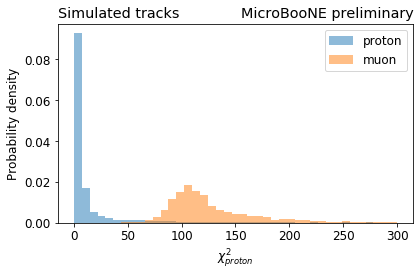

In [82]:
var = 'trk_pid_chipr_y'
bins = 41
range = [0, 300]
caloLike_test.plotVariableMC(var, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', alpha=0.5);
caloLike_test.plotVariableMCFancy(var, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', alpha=0.5);
plt.xlabel('$\chi^2_{proton}$')
plt.tight_layout()
# plt.savefig(save_folder + 'chi2_proton_muon.png', dpi=250)

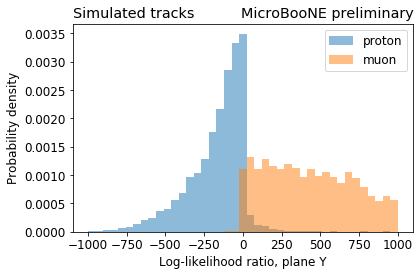

In [83]:
var = 'log_like_ratio_2'
bins = 41
range = [-1000, 1000]
caloLike_test.plotVariableMC(var, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', alpha=0.5);
caloLike_test.plotVariableMCFancy(var, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', alpha=0.5);
plt.xlabel('Log-likelihood ratio, plane Y')
plt.tight_layout()
# plt.savefig(save_folder + 'LLR_y_proton_muon.png', dpi=250)

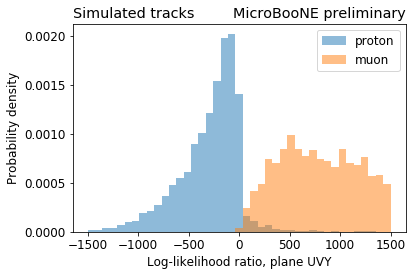

In [84]:
var = 'log_like_ratio'
bins = 41
range = [-1500, 1500]
caloLike_test.plotVariableMC(var, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', alpha=0.5);
caloLike_test.plotVariableMCFancy(var, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', alpha=0.5);
plt.xlabel('Log-likelihood ratio, plane UVY')
plt.tight_layout()
# plt.savefig(save_folder + 'LLR_uvy_proton_muon.png', dpi=250)

## ROC curves

Text(1.0, 1.0, 'MicroBooNE preliminary')

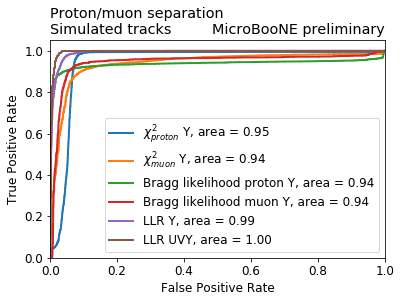

In [87]:
selection = selection_for_test

caloLike_test.rocCurve(variable='trk_pid_chipr_y', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='$\chi^2_{proton}$ Y')

caloLike_test.rocCurve(variable='trk_pid_chimu_y', 
     pdg_codes=[2212, 13], 
     selection_function=selection, 
     plot=True,
     variable_label='$\chi^2_{muon}$ Y')

caloLike_test.rocCurve(variable='trk_bragg_p_y', 
     pdg_codes=[2212, 13], 
     selection_function=selection, 
     plot=True,
     variable_label='Bragg likelihood proton Y')

caloLike_test.rocCurve(variable='trk_bragg_mu_y', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='Bragg likelihood muon Y')

caloLike_test.rocCurve(variable='log_like_ratio_2', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='LLR Y')

caloLike_test.rocCurve(variable='log_like_ratio', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='LLR UVY')

plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
# plt.savefig(save_folder + 'roc_curves.png', dpi=250)

(0.8, 1)

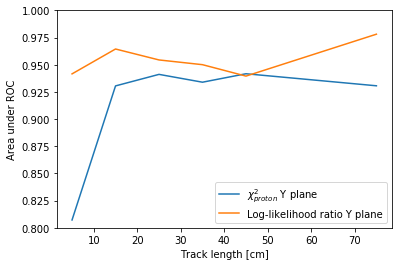

In [102]:
def selection(array, bin_range):
    return selection_for_train(array) &\
              ~np.isnan(array['log_like_ratio']) &\
              ~np.isinf(array['log_like_ratio']) &\
           (array['trk_len'] >= bin_range[0]) &\
           (array['trk_len'] < bin_range[1])

track_len_binning = [0, 10, 20, 30, 40, 50, 100]
roc_chi2 = []
roc_like_u = []
bin_centers = []
for binning in zip(track_len_binning[:-1], track_len_binning[1:]):
    bin_centers.append((binning[0] + binning[1])/2)
    
    roc_chi2.append(caloLike_test.rocCurve(variable='trk_pid_chipr', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='$\chi^2_{proton}$ y plane',
         bin_range=binning))

    roc_like_u.append(caloLike_test.rocCurve(variable='log_like_ratio_2', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio Y plane',
         bin_range=binning))
    
plt.plot(bin_centers, roc_chi2,
         label='$\chi^2_{proton}$ Y plane')
plt.plot(bin_centers, roc_like_u,
         label='Log-likelihood ratio Y plane')
plt.legend()
plt.xlabel('Track length [cm]')
plt.ylabel('Area under ROC')
plt.ylim(0.8, 1)
plt.savefig(save_folder + 'roc_curves.png', dpi=250)

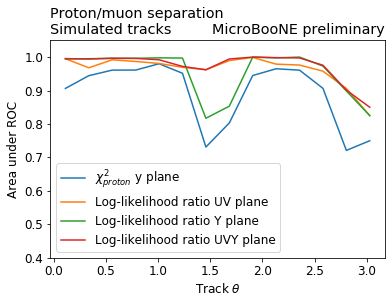

In [135]:
def selection(array, bin_range):
    return selection_for_test(array) &\
           (array['trk_theta'] >= bin_range[0]) &\
           (array['trk_theta'] < bin_range[1])

track_len_binning = np.linspace(0, math.pi, 15)
roc_chi2 = []
roc_like_uv = []
roc_like_y = []
roc_like_uvy = []
bin_centers = []
for binning in zip(track_len_binning[:-1], track_len_binning[1:]):
    bin_centers.append((binning[0] + binning[1])/2)
    
    roc_chi2.append(caloLike_test.rocCurve(variable='trk_pid_chipr', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='$\chi^2_{proton}$ y plane',
         bin_range=binning))

    roc_like_uv.append(caloLike_test.rocCurve(variable='log_like_ratio_01', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UV plane',
         bin_range=binning))
    
    roc_like_y.append(caloLike_test.rocCurve(variable='log_like_ratio_2', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio Y plane',
         bin_range=binning))
    
    roc_like_uvy.append(caloLike_test.rocCurve(variable='log_like_ratio', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UVY plane',
         bin_range=binning))
    
plt.plot(bin_centers, roc_chi2,
         label='$\chi^2_{proton}$ y plane')
plt.plot(bin_centers, roc_like_uv,
         label='Log-likelihood ratio UV plane')
plt.plot(bin_centers, roc_like_y,
         label='Log-likelihood ratio Y plane')
plt.plot(bin_centers, roc_like_uvy,
         label='Log-likelihood ratio UVY plane')
plt.legend()
plt.xlabel(r'Track $\theta$')
plt.ylabel('Area under ROC')
plt.ylim(0.4, 1.05)
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.savefig(save_folder + 'roc_curve_theta.png', dpi=250)

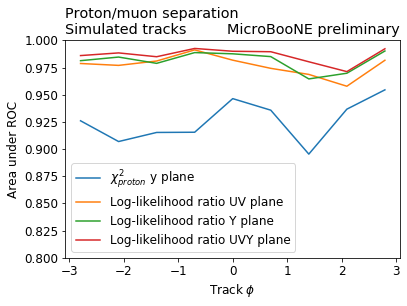

In [136]:
def selection(array, bin_range):
    return selection_for_test(array) &\
           (array['trk_phi'] >= bin_range[0]) &\
           (array['trk_phi'] < bin_range[1])

track_len_binning = np.linspace(-math.pi, math.pi, 10)
roc_chi2 = []
roc_like_uv = []
roc_like_y = []
roc_like_uvy = []
bin_centers = []
for binning in zip(track_len_binning[:-1], track_len_binning[1:]):
    bin_centers.append((binning[0] + binning[1])/2)
    
    roc_chi2.append(caloLike_test.rocCurve(variable='trk_pid_chipr', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='$\chi^2_{proton}$ y plane',
         bin_range=binning))

    roc_like_uv.append(caloLike_test.rocCurve(variable='log_like_ratio_01', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UV plane',
         bin_range=binning))
    
    roc_like_y.append(caloLike_test.rocCurve(variable='log_like_ratio_2', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio Y plane',
         bin_range=binning))
    
    roc_like_uvy.append(caloLike_test.rocCurve(variable='log_like_ratio', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UVY plane',
         bin_range=binning))
    
plt.plot(bin_centers, roc_chi2,
         label='$\chi^2_{proton}$ y plane')
plt.plot(bin_centers, roc_like_uv,
         label='Log-likelihood ratio UV plane')
plt.plot(bin_centers, roc_like_y,
         label='Log-likelihood ratio Y plane')
plt.plot(bin_centers, roc_like_uvy,
         label='Log-likelihood ratio UVY plane')
plt.legend()
plt.xlabel(r'Track $\phi$')
plt.ylabel('Area under ROC')
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.ylim(0.8, 1)
plt.savefig(save_folder + 'roc_curve_phi.png', dpi=250)

In [17]:
mask = (array_train['backtracked_end_process'].regular() != b'FastScintillation') &\
        (array_train['backtracked_end_process'].regular() != b'') &\
        (array_train['backtracked_end_process'].regular() != b'phot')

In [18]:
array_train['backtracked_end_process'][mask]

<ObjectArray [b'CoupledTransportation' b'CoupledTransportation' b'nCapture' ... b'nCapture' b'nCapture' b'CoupledTransportation'] at 0x7f3a9c3587d0>

In [21]:
proton = (array_train['backtracked_pdg'] == 2212)

In [22]:
array_train['backtracked_end_process'][proton]

<ObjectArray [b'FastScintillation' b'FastScintillation' b'FastScintillation' ... b'FastScintillation' b'FastScintillation' b'FastScintillation'] at 0x7f3a9c378b90>